# Boruta Trial

Playing around with Boruta ([Source](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a))

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import scipy as sp
from boruta import BorutaPy
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
### make X and y
X = pd.DataFrame(
    {
        "age": [25, 32, 47, 51, 62],
        "height": [182, 176, 174, 168, 181],
        "weight": [75, 71, 78, 72, 86],
    }
)
y = pd.Series([20, 32, 45, 55, 61], name="income")

<IPython.core.display.Javascript object>

* In Boruta, features do not compete among themselves. Instead — and this is the first brilliant idea — they compete with a randomized version of them.
* In practice, starting from X, another dataframe is created by randomly shuffling each feature. These permuted features are called shadow features.

In [3]:
### make X_shadow by randomly permuting each column of X
np.random.seed(42)
X_shadow = X.apply(np.random.permutation)
X_shadow.columns = ["shadow_" + feat for feat in X.columns]
### make X_boruta by appending X_shadow to X
X_boruta = pd.concat([X, X_shadow], axis=1)

<IPython.core.display.Javascript object>

In [4]:
X_boruta

,age,height,weight,shadow_age,shadow_height,shadow_weight
0,25,182,75,32,168,71
1,32,176,71,62,176,75
2,47,174,78,47,174,72
3,51,168,72,25,182,86
4,62,181,86,51,181,78


<IPython.core.display.Javascript object>

* Now, we take the importance of each original features and compare it with a threshold. 
* This time, the threshold is defined as the highest feature importance recorded among the shadow features. 
* When the importance of a feature is higher than this threshold, this is called a “hit”. 
> The idea is that a feature is useful only if it’s capable of doing better than the best randomized feature.

In [5]:
### fit a random forest (suggested max_depth between 3 and 7)
forest = RandomForestRegressor(max_depth=5, random_state=42)
forest.fit(X_boruta, y)
### store feature importances
feat_imp_X = forest.feature_importances_[: len(X.columns)]
feat_imp_shadow = forest.feature_importances_[len(X.columns) :]
### compute hits
hits = feat_imp_X > feat_imp_shadow.max()

<IPython.core.display.Javascript object>

In [6]:
pd.DataFrame(
    [np.concatenate((feat_imp_X * 100, feat_imp_shadow * 100)), hits],
    columns=X_boruta.columns,
    index=["feature importance %", "hits"],
)

,age,height,weight,shadow_age,shadow_height,shadow_weight
feature importance %,28.112381,15.808892,9.25464,10.162149,21.182001,15.479937
hits,True,False,False,NaN,NaN,NaN


<IPython.core.display.Javascript object>

Apparently, we should drop weight and get on with age and height. But should we trust this run? What if it was just an unlucky run for weight? What if instead it was just a lucky run for age and height?

In [7]:
### initialize hits counter
hits = np.zeros((len(X.columns)))

### repeat 20 times
for iter_ in range(20):
    ### make X_shadow by randomly permuting each column of X
    np.random.seed(iter_)
    X_shadow = X.apply(np.random.permutation)
    X_boruta = pd.concat([X, X_shadow], axis=1)

    ### fit a random forest (suggested max_depth between 3 and 7)
    forest = RandomForestRegressor(max_depth=5, random_state=42)
    forest.fit(X_boruta, y)

    ### store feature importance
    feat_imp_X = forest.feature_importances_[: len(X.columns)]
    feat_imp_shadow = forest.feature_importances_[len(X.columns) :]

    ### compute hits for this trial and add to counter
    hits += feat_imp_X > feat_imp_shadow.max()

<IPython.core.display.Javascript object>

In [8]:
pd.DataFrame([hits], columns=X.columns, index=["hits"])

,age,height,weight
hits,18.0,5.0,0.0


<IPython.core.display.Javascript object>

## Binomial Distribution

**Now, how do we set a decision criterion?**
* What is the probability that we shall keep it? 
* The maximum level of uncertainty about the feature is expressed by a probability of 50%, like tossing a coin. 
* Since each independent experiment can give a binary outcome (hit or no hit), a series of n trials follows a binomial distribution.

In [9]:
trials = 20
pmf = [sp.stats.binom.pmf(x, trials, 0.5) for x in range(trials + 1)]

<IPython.core.display.Javascript object>

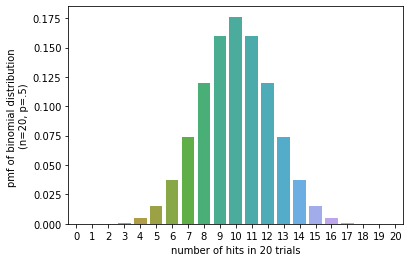

<IPython.core.display.Javascript object>

In [10]:
ax = sns.barplot(data=pd.DataFrame([(i, j) for i, j in enumerate(pmf)]), x=0, y=1)
ax.set_xlabel("number of hits in 20 trials")
ax.set_ylabel("pmf of binomial distribution \n(n=20, p=.5)")
plt.show()

![Img](https://miro.medium.com/1*yqAUlMtPUiFyr8gYLFagTA.png)

In Boruta, there is not a hard threshold between a refusal and an acceptance area. Instead, there are 3 areas:
* an area of refusal (the red area): the features that end up here are considered as noise, so they are dropped;
    - having 0 - 5 hits has a low probability
    - we're not interested in features that have low hits
* an area of irresolution (the blue area): Boruta is indecisive about the features that are in this area;
* an area of acceptance (the green area): the features that are here are considered as predictive, so they are kept.
    - having 16+ hits has a low probability
    - a likelihood of having those high hits is low, hence the feature must be important and not chosen just by a factor of chance

So, we did 20 iterations on our toy data and ended up with some statistically grounded conclusions:
* in order to predict the income of a person, age is predictive and should be kept, weight is just noise and should be dropped,
* Boruta was indecisive about height: the choice is up to us, but in a conservative frame, it is advisable to keep it.

## BorutaPy

In [11]:
###initialize Boruta
forest = RandomForestRegressor(n_jobs=-1, max_depth=5)
boruta = BorutaPy(
    estimator=forest, n_estimators="auto", max_iter=100  # number of trials to perform
)

### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X), np.array(y))

### print results
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()

print("features in the green area:", green_area)
print("features in the blue area:", blue_area)

features in the green area: []
features in the blue area: ['age']


<IPython.core.display.Javascript object>

Feature selection is a decisive part of a machine learning pipeline: being too conservative means introducing unnecessary noise, while being too aggressive means throwing away useful information.